# Import

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib import rcParams
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.metrics import r2_score 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

%matplotlib inline
#%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)


2.19.0


## load dataset

In [2]:
dataset = pd.read_csv("C:/Users/User/Documents/GitHub/Health-impacts-of-air-pollution/AirData/SecundaIM.csv", sep =';', header=0, index_col=0)
values = dataset.values

## Plot pm2.5

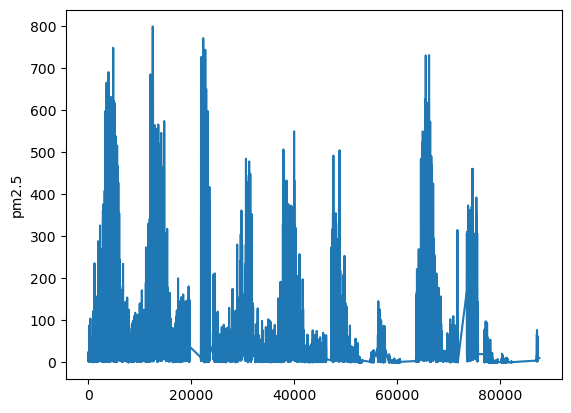

In [3]:
plt.plot(values[:,0])
plt.ylabel(dataset.columns[0])
plt.show()

## Data preparation

We need a way to prepare the data for whatever way we would like to formulate the problem.

In this case we are formulating it such that we take in 1 time step input (14 variables) and output 1 time step output (1 variable). In other words we are trying to solve the following question: given the pollution and weather conditions of the previous hour, can we predict the PM2.5 level for the next hour.

The single variable we are outputing is the PM2.5 level. Note we also use PM2.5 level in our input.

Credit for this code: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Get column names

In [5]:
dataset.columns

Index(['pm2.5', 'pm10', 'so2', 'no2', 'no', 'nox', 'o3', 'co', 'ws', 'wd',
       'temp', 'relHum', 'pressure'],
      dtype='object')

##Actually perform the data preparation

We scale the values between 0 and 1.

The code which converts the data into the suitable way we want, in this case, will produce 14 output variables. In our case we only want to predict PM2.5, that is why we drop the other collumns from the dataframe.

Credit for this code: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [6]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

n_vars = scaled.shape[1] 

# drop columns we don't want to predict
# We drop these because we are only interested in predicting for a single variable (pollution).
# If we don't drop, then we will be predicting for all the variables too!
#reframed.drop(reframed.columns[[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]], axis=1, inplace=True)
#values = reframed.values

drop = list(range(n_vars+1, 2*n_vars))
reframed.drop(reframed.columns[drop], axis=1, inplace=True)
values = reframed.values

## View the data

In [7]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var1(t)
1,0.011986,0.006100,0.023296,0.092911,0.004285,0.008461,0.112376,0.002042,0.090452,0.590283,0.402746,0.963322,0.439276,0.006124
2,0.006124,0.002865,0.023639,0.092911,0.003727,0.008961,0.112376,0.001518,0.132328,0.354881,0.388917,0.963322,0.433491,0.013940
3,0.013940,0.006125,0.021446,0.092911,0.005609,0.027036,0.112376,0.002042,0.251256,0.194289,0.386283,0.914322,0.387226,0.011498
4,0.011498,0.005003,0.030219,0.092911,0.004982,0.034272,0.112376,0.001518,0.263819,0.164342,0.392868,0.852513,0.354538,0.008492
5,0.008492,0.003967,0.026175,0.092911,0.005121,0.023401,0.112376,0.000995,0.187605,0.205595,0.408015,0.784106,0.329393,0.011398


## Create X and Y variables

In [8]:
values.shape

(87646, 14)

In [9]:
X = values[:,:-1]

In [10]:
Y = values[:,-1]

## Check the shapes

In [11]:
X.shape

(87646, 13)

In [12]:
Y.shape

(87646,)

## Reshaping

The format that Keras expects is [batches, timesteps, features]

In [13]:
X = X.reshape(X.shape[0],1,X.shape[1])

In [14]:
X.shape

(87646, 1, 13)

## Training, validation and testing split

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

## Check the shape

In [16]:
print ('X_train:',X_train.shape)
print ('Y_train:',Y_train.shape)
print ()
print ('X_val:',X_val.shape)
print ('Y_val:',Y_val.shape)
print ()
print ('X_test:',X_test.shape)
print ('Y_test:',Y_test.shape)

X_train: (56092, 1, 13)
Y_train: (56092,)

X_val: (14024, 1, 13)
Y_val: (14024,)

X_test: (17530, 1, 13)
Y_test: (17530,)


## Define a model

In [17]:
model = Sequential()
model.add(LSTM(56, input_shape=(1, 13)))
model.add(Dense(56, activation="relu"))
model.add(Dense(56, activation="relu"))
model.add(Dense(56, activation="relu"))
model.add(Dense(56, activation="relu"))
model.add(Dense(56, activation="relu"))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='mse', optimizer='adam')

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Print summary

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 56)             │        15,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 56)             │         3,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │         3,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 56)             │         3,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 56)             │         3,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 56)             │         3,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            57 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,697 (123.82 KB)

 Trainable params: 31,697 (123.82 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [19]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, batch_size=16, verbose=1)

Epoch 1/30
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0082 - val_loss: 0.0011
Epoch 2/30
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 3/30
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/30
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 5/30
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 6/30
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/30
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/30
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/30
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/30
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 11/30
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 12/30
3506/3506 ━━━━━━━

## Predict

In [20]:
prediction = model.predict(X_test)

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [21]:
def unscale(scaled_value):
    # if target variable is the first column, then, data_max_[0]
    unscaled_value = scaled_value * (scaler.data_max_[0] - scaler.data_min_[0]) + (scaler.data_min_[0])
    return unscaled_value

In [22]:
predictions = unscale(prediction)

In [23]:
Y_tests = unscale(Y_test)

# Plot the performance

In [24]:
mean_absolute_error(Y_tests, predictions)

10.55292797088623

In [25]:
rmse = sqrt(mean_squared_error(Y_tests, predictions))
print(rmse)

27.126720180550876


In [26]:
r2_score(Y_tests, predictions)

0.6982223391532898

## Compare prediction and testing data

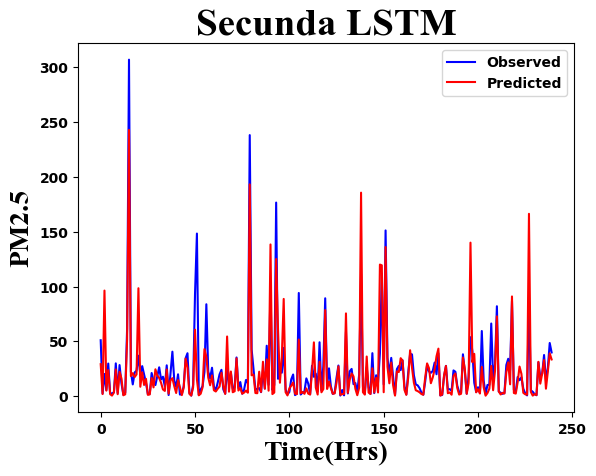

In [27]:
rcParams['font.weight'] = 'bold'
plt.plot(Y_tests[0:240], color='blue', label = 'Observed')
plt.plot(predictions[0:240], color='red', label = 'Predicted')
plt.ylabel('PM2.5', fontname="Times New Roman", size=20,fontweight="bold")
plt.xlabel('Time(Hrs)', fontname="Times New Roman", size=20,fontweight="bold")
plt.title('Secunda LSTM', fontname="Times New Roman", size=28,fontweight="bold")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)
plt.savefig("C:/Users/User/Documents/GitHub/Health-impacts-of-air-pollution/PLOTS/SecLSTMPred.png", dpi=300, bbox_inches='tight')
plt.show()

# Test

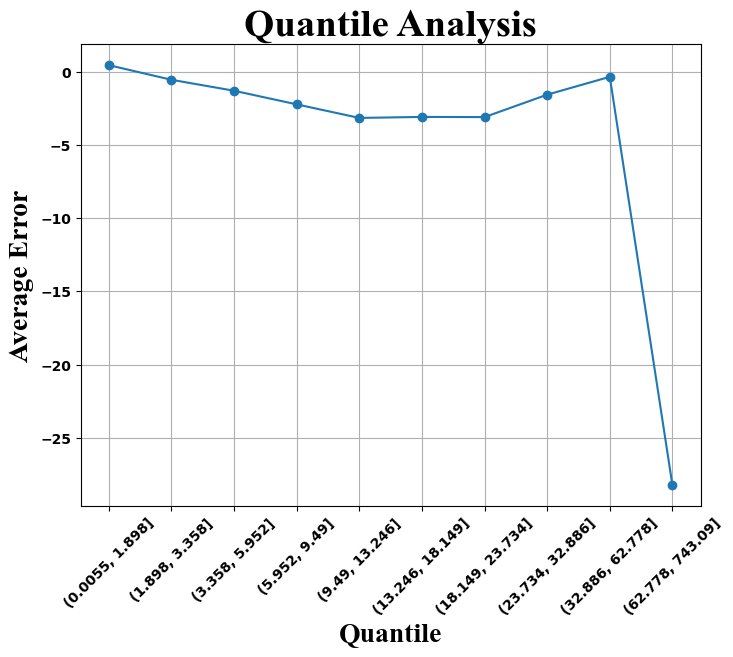

In [28]:
## Calculate errors
errors = predictions.flatten() - Y_tests

# Calculate quantiles based on actual values
quantiles, bins = pd.qcut(Y_tests, q=10, duplicates='drop', retbins=True)

# Calculate average error for each quantile
quantile_errors = []
for i in range(len(bins) - 1):
    group_indices = np.where((Y_tests >= bins[i]) & (Y_tests < bins[i+1]))[0]
    quantile_errors.append(errors[group_indices].mean())

# Plot quantiles vs. average errors
rcParams['font.weight'] = 'bold'
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(quantiles.categories) + 1), quantile_errors, marker='o')
plt.xlabel('Quantile', fontname="Times New Roman", size=20,fontweight="bold")
plt.ylabel('Average Error', fontname="Times New Roman", size=20,fontweight="bold")
plt.title('Quantile Analysis', fontname="Times New Roman", size=28,fontweight="bold")
plt.xticks(range(1, len(quantiles.categories) + 1), [str(q) for q in quantiles.categories], rotation=45)
plt.grid(True)
plt.savefig("C:/Users/User/Documents/GitHub/Health-impacts-of-air-pollution/PLOTS/SecLSTMQuan.png", dpi=300, bbox_inches='tight')
plt.show()


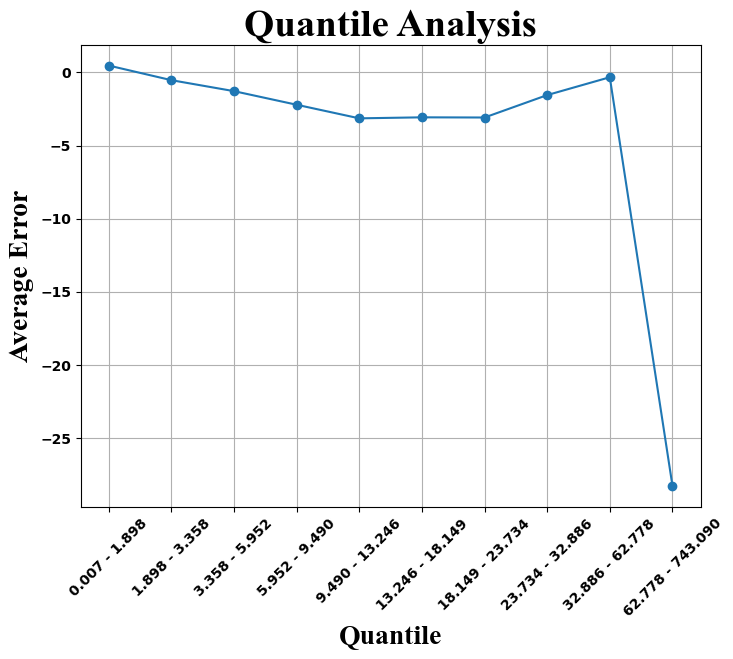

In [29]:
errors = predictions.flatten() - Y_tests

# Calculate quantiles based on actual values
quantiles, bins = pd.qcut(Y_tests, q=10, duplicates='drop', retbins=True)

# Calculate average error for each quantile
quantile_errors = []
for i in range(len(bins) - 1):
    group_indices = np.where((Y_tests >= bins[i]) & (Y_tests < bins[i+1]))[0]
    quantile_errors.append(errors[group_indices].mean())

# Round the bin edges for better readability
rounded_bins = np.round(bins, decimals=3)

# Plot quantiles vs. average errors
rcParams['font.weight'] = 'bold'
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(quantiles.categories) + 1), quantile_errors, marker='o')
plt.xlabel('Quantile', fontname="Times New Roman", size=20, fontweight="bold")
plt.ylabel('Average Error', fontname="Times New Roman", size=20, fontweight="bold")
plt.title('Quantile Analysis', fontname="Times New Roman", size=28, fontweight="bold")
plt.xticks(range(1, len(quantiles.categories) + 1), [f'{rounded_bins[i]:.3f} - {rounded_bins[i+1]:.3f}' for i in range(len(rounded_bins) - 1)], rotation=45)
plt.grid(True)
plt.show()

SHAP

In [30]:
import shap
import numpy as np

# Sample a subset of the test set (SHAP is computationally expensive)
#X_test_sample = X_test[:10]  # Use a small sample for demonstration (First 10)
X_test_sample = X_test[np.random.choice(X_test.shape[0], 100, replace=False)] #(random 10)

# Reshape the 3D data into 2D for SHAP (flatten time steps and features)
X_train_flattened = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test_sample_flattened = X_test_sample.reshape((X_test_sample.shape[0], X_test_sample.shape[1] * X_test_sample.shape[2]))

# Create a SHAP KernelExplainer using the model's prediction function
explainer = shap.KernelExplainer(
    lambda x: model.predict(x.reshape((x.shape[0], 1, X.shape[2]))).reshape(-1),  # Ensure the output is 1D
    X_train_flattened[:100])

# Calculate SHAP values for the test sample
shap_values = explainer.shap_values(X_test_sample_flattened)

# Feature names (flattened time steps and features)
flattened_feature_names = [f"{feature}" for i in range(1) for feature in dataset.columns]

# Ensure the length of feature names matches the number of features
assert len(flattened_feature_names) == X_test_sample_flattened.shape[1], "Feature names length mismatch."

# Plot summary plot of SHAP values
shap.summary_plot(shap_values, X_test_sample_flattened, feature_names=flattened_feature_names, show=False)

plt.savefig("C:/Users/User/Documents/GitHub/Health-impacts-of-air-pollution/PLOTS/SecLSTMshap.png", dpi=300, bbox_inches='tight')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6482/6482 ━━━━━━━━━━━━━━━━━━━━ 6s 966us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6482/6482 ━━━━━━━━━━━━━━━━━━━━ 6s 988us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6482/6482 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6482/6482 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6482/6482 ━━━━━━━━━━━━━━━━━━━━ 6s 935us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6482/6482 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6482/6482 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6482/6482 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6482/6482 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6482/6482 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6482/6482 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6482/6482 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━

# Save Model

In [ ]:
# eMalahleni PM2.5
#model.save('lstm_model.h5')
#model.save('lstm_modelPM1.h5')
#model.save('lstm_modelSO2.h5')
#model.save('lstm_modelNO2.h5')

In [ ]:
# Ermelo PM2.5
#model.save('lstm_modelEPM2.h5')
#model.save('lstm_modelEPM1.h5')
#model.save('lstm_modelESO2.h5')
#model.save('lstm_modelENO2.h5')

In [ ]:
# Hendrina PM2.5
#model.save('lstm_modelHPM2.h5')
#model.save('lstm_modelHPM1.h5')
#model.save('lstm_modelHSO2.h5')
#model.save('lstm_modelHNO2.h5')

In [ ]:
# Middelburg PM2.5
#model.save('lstm_modelMPM2.h5')
#model.save('lstm_modelMPM1.h5')
#model.save('lstm_modelMSO2.h5')
#model.save('lstm_modelMNO2.h5')

In [ ]:
# Secunda PM2.5
#model.save('lstm_modelSPM2.h5')
#model.save('lstm_modelSPM1.h5')
#model.save('lstm_modelSSO2.h5')
#model.save('lstm_modelSNO2.h5')

In [ ]:
loaded_model = load_model('lstm_model.h5')

In [ ]:
# Make predictions using the loaded model
predictions = loaded_model.predict(X_test)

# Inverse transform the predictions to get the actual PM2.5 concentrations
predictions_inv = scaler_y.inverse_transform(predictions)

   # Forecast

In [ ]:
mean_absolute_error(Y_test[1:12], prediction[1:12])

In [ ]:
mean_absolute_error(Y_test[1:18], prediction[1:18])

In [ ]:
mean_absolute_error(Y_test[1:24], prediction[1:24])

In [ ]:
mean_absolute_error(Y_test[1:36], prediction[1:36])

In [ ]:
mean_absolute_error(Y_test[1:48], prediction[1:48])

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:6], prediction[1:6]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:12], prediction[1:12]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:18], prediction[1:18]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:24], prediction[1:24]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:36], prediction[1:36]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:48], prediction[1:48]))
print(rmse)